In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
from copy import deepcopy
import plotly.express as px
import statsmodels.formula.api as smf

results = pd.read_csv("qr_code_reader_results.csv")
results

,diameter_mm,qr_side_length_mm,camera_distance_mm,focal_length_mm,sphere_rotation_degrees,image_width_pixels,image_height_pixels,filename,QReader Correct,OpenCV Correct,pyzbar Correct
0,30.0,5,150.0,5.1,180.0,3024,4032,C:\Users\haroldj\Downloads\QR_Images\sphere_d_...,1,1,1
1,30.0,5,200.0,5.1,180.0,3024,4032,C:\Users\haroldj\Downloads\QR_Images\sphere_d_...,1,1,0
2,30.0,5,250.0,5.1,180.0,3024,4032,C:\Users\haroldj\Downloads\QR_Images\sphere_d_...,1,0,1
3,30.0,5,300.0,5.1,180.0,3024,4032,C:\Users\haroldj\Downloads\QR_Images\sphere_d_...,1,0,1
4,30.0,5,400.0,5.1,180.0,3024,4032,C:\Users\haroldj\Downloads\QR_Images\sphere_d_...,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
379,120.0,25,300.0,5.1,180.0,3024,4032,C:\Users\haroldj\Downloads\QR_Images\sphere_d_...,1,1,1
380,120.0,25,400.0,5.1,180.0,3024,4032,C:\Users\haroldj\Downloads\QR_Images\sphere_d_...,1,1,1
381,120.0,25,500.0,5.1,180.0,3024,4032,C:\Users\haroldj\Downloads\QR_Images\sphere_d_...,1,1,1
382,120.0,25,600.0,5.1,180.0,3024,4032,C:\Users\haroldj\Downloads\QR_Images\sphere_d_...,1,1,1


### Functions

In [2]:
def analyse_data(df: pd.DataFrame, primary: list, secondary: str, response: str = 'Response', order='auto', regression_type='logistic', plot_ratio_contour=False, secondary_value_for_plot=None):
    """
    Analyzes data with a specified regression model, allows selection of primary
    and secondary variables, model order, and regression type.
    Optionally computes and displays contour plots.

    Args:
        df: Pandas DataFrame containing the data.
        primary: A list of two variable names that are the primary variables.
        secondary: The name of the secondary variable.
        response: The name of the response variable (default: 'Response').
        order: 'auto', 'first', or 'second' (default: 'auto').
        regression_type: 'logistic' or 'linear' (default: 'logistic').
        plot_ratio_contour: Boolean, whether to plot the ratio contour (default: False).
        secondary_value_for_plot: Optional float, the value at which to hold the
                                   secondary variable for visualizations. If None, the mean
                                   of the secondary variable is used.
    """

    # --- 1. Load and Prepare Data ---

    df.columns = df.columns.str.replace(' ', '') # remove spaces in column names
    primary = [item.replace(' ', '') for item in primary]
    secondary = secondary.replace(' ', '')
    response = response.replace(' ', '')

    df = df.dropna(subset=[response]) # drop rows with empty response values

    # Convert boolean response to numerical (0 and 1) if using logistic regression
    if regression_type == 'logistic':
        df[response] = df[response].astype(int)

    # --- 2. Model Fitting ---

    # Create interaction and squared terms in the DataFrame
    df[f'{primary[0]}:{primary[1]}'] = df[primary[0]] * df[primary[1]]
    df[f'{primary[0]}:{secondary}'] = df[primary[0]] * df[secondary]
    df[f'{primary[1]}:{secondary}'] = df[primary[1]] * df[secondary]
    df[f'{primary[0]}_sq'] = df[primary[0]] ** 2
    df[f'{primary[1]}_sq'] = df[primary[1]] ** 2
    df[f'{secondary}_sq'] = df[secondary] ** 2

    # Define the model formula based on the order
    if order == 'first':
        formula = f"{response} ~ {primary[0]} + {primary[1]} + {secondary}"
    elif order == 'second':
        formula = f"{response} ~ {primary[0]} + {primary[1]} + {secondary} + " \
                  f"{primary[0]}:{primary[1]} + {primary[0]}:{secondary} + {primary[1]}:{secondary} + " \
                  f"I({primary[0]}**2) + I({primary[1]}**2) + I({secondary}**2)"
    elif order == 'auto':
        # Fit both first and second order models for auto selection
        formula_first_order = f"{response} ~ {primary[0]} + {primary[1]} + {secondary}"
        formula_second_order = f"{response} ~ {primary[0]} + {primary[1]} + {secondary} + " \
                               f"{primary[0]}:{primary[1]} + {primary[0]}:{secondary} + {primary[1]}:{secondary} + " \
                               f"I({primary[0]}**2) + I({primary[1]}**2) + I({secondary}**2)"
    else:
        raise ValueError("Invalid 'order' argument. Choose 'auto', 'first', or 'second'.")

    # Select the appropriate statsmodels function based on regression_type
    if regression_type == 'logistic':
        model_func = smf.logit
    elif regression_type == 'linear':
        model_func = smf.ols
    else:
        raise ValueError("Invalid 'regression_type' argument. Choose 'logistic' or 'linear'.")

    # Fit the model(s)
    if order == 'auto':
        model_first_order = model_func(formula_first_order, data=df).fit(maxiter=1000) # Increased maxiter
        model_second_order = model_func(formula_second_order, data=df).fit(maxiter=1000) # Increased maxiter

        print("First-order model summary:")
        print(model_first_order.summary())
        print("\nSecond-order model summary:")
        print(model_second_order.summary())

        # Compare AIC values for auto selection
        aic_first_order = model_first_order.aic
        aic_second_order = model_second_order.aic
        print(f"\nAIC - First-order model: {aic_first_order:.2f}")
        print(f"AIC - Second-order model: {aic_second_order:.2f}")

        if aic_first_order < aic_second_order:
            chosen_model = model_first_order
            print("\nFirst-order model selected based on lower AIC.")
        else:
            chosen_model = model_second_order
            print("\nSecond-order model selected based on lower AIC.")
    else:
        chosen_model = model_func(formula, data=df).fit(maxiter=1000) # Increased maxiter
        print(f"{order.capitalize()}-order model summary:")
        print(chosen_model.summary())

    # Check for multicollinearity (only if a model was successfully fit)
    if chosen_model is not None:
        print("\n--- Multicollinearity Check (VIF) ---")
        if order == 'first':
            vif_data = df[[primary[0], primary[1], secondary]]
        else:
            vif_data = df[[primary[0], primary[1], secondary, f'{primary[0]}:{primary[1]}',
                           f'{primary[0]}:{secondary}', f'{primary[1]}:{secondary}',
                           f'{primary[0]}_sq', f'{primary[1]}_sq', f'{secondary}_sq']]
        vif = pd.DataFrame()
        vif["feature"] = vif_data.columns
        vif["VIF"] = [variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])]
        print(vif)

    # --- 3. Visualizations ---
    if chosen_model is not None:
        # Generate a grid of points for the primary variables
        primary0_range = np.linspace(df[primary[0]].min(), df[primary[0]].max(), 100)
        primary1_range = np.linspace(df[primary[1]].min(), df[primary[1]].max(), 100)
        primary0_grid, primary1_grid = np.meshgrid(primary0_range, primary1_range)

        # Determine the value to hold the secondary variable at
        if secondary_value_for_plot is None:
            secondary_hold_value = np.mean(df[secondary])
        else:
            secondary_hold_value = secondary_value_for_plot

        # Create a DataFrame for predictions
        predict_df = pd.DataFrame({
            primary[0]: primary0_grid.ravel(),
            primary[1]: primary1_grid.ravel(),
            secondary: secondary_hold_value,  # Use the specified or mean value
            f'{primary[0]}_sq': primary0_grid.ravel()**2,
            f'{primary[1]}_sq': primary1_grid.ravel()**2,
            f'{secondary}_sq': secondary_hold_value**2,
            f'{primary[0]}:{primary[1]}': primary0_grid.ravel() * primary1_grid.ravel(),
            f'{primary[0]}:{secondary}': primary0_grid.ravel() * secondary_hold_value,
            f'{primary[1]}:{secondary}': primary1_grid.ravel() * secondary_hold_value
        })

        # Predict response values using the chosen model
        predicted_response = chosen_model.predict(predict_df)
        predicted_probs = np.array(predicted_response).reshape(primary0_grid.shape)

        # 3D Surface Plot
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        surface = ax.plot_surface(primary0_grid, primary1_grid, predicted_probs, cmap='viridis', alpha=0.8)
        ax.set_xlabel(primary[0])
        ax.set_ylabel(primary[1])
        ax.set_zlabel('Predicted Response')
        ax.set_title('Response Surface')
        fig.colorbar(surface, shrink=0.5, aspect=10)

        # Contour Plot of Primary Variables
        fig, ax = plt.subplots(figsize=(8, 6))
        contour = ax.contour(primary0_grid, primary1_grid, predicted_probs, cmap='viridis')
        ax.clabel(contour, inline=True, fontsize=8)
        ax.set_xlabel(primary[0])
        ax.set_ylabel(primary[1])
        ax.set_title('Contour Plot of Response Surface')

        if plot_ratio_contour:
            # Contour Plot of (Code Size / Diameter) vs Distance
            fig_ratio, ax_ratio = plt.subplots(figsize=(8, 6))

            # Generate grid for ratio and secondary variable
            ratio_range = np.linspace((df[primary[1]] / df[primary[0]]).min(), (df[primary[1]] / df[primary[0]]).max(), 100)
            secondary_range = np.linspace(df[secondary].min(), df[secondary].max(), 100)
            ratio_grid, secondary_grid = np.meshgrid(ratio_range, secondary_range)

            # Vectorized prediction
            mean_diameter = df[primary[0]].mean()
            current_code_size_grid = ratio_grid * mean_diameter

            predict_df_ratio = pd.DataFrame({
                primary[0]: np.full(ratio_grid.size, mean_diameter), # Fill with mean diameter
                primary[1]: current_code_size_grid.ravel(),
                secondary: secondary_grid.ravel(),
                f'{primary[0]}_sq': np.full(ratio_grid.size, mean_diameter**2),
                f'{primary[1]}_sq': current_code_size_grid.ravel()**2,
                f'{secondary}_sq': secondary_grid.ravel()**2,
                f'{primary[0]}:{primary[1]}': mean_diameter * current_code_size_grid.ravel(),
                f'{primary[0]}:{secondary}': mean_diameter * secondary_grid.ravel(),
                f'{primary[1]}:{secondary}': current_code_size_grid.ravel() * secondary_grid.ravel()
            })

            predicted_response_ratio = chosen_model.predict(predict_df_ratio).values.reshape(ratio_grid.shape)

            contour_ratio = ax_ratio.contour(ratio_grid, secondary_grid, predicted_response_ratio, cmap='viridis')
            ax_ratio.clabel(contour_ratio, inline=True, fontsize=8)
            ax_ratio.set_xlabel(f'{primary[1]} / {primary[0]}')
            ax_ratio.set_ylabel(secondary)
            ax_ratio.set_title(f'Contour Plot of Response vs ({primary[1]} / {primary[0]}) and {secondary}')

        plt.tight_layout()
        plt.show()

        # --- 4. Optimization ---
        # Define the objective function
        def objective_function(x):
            input_data = {
                primary[0]: x[0],
                primary[1]: x[1],
                secondary: x[2],
                f'{primary[0]}_sq': x[0]**2,
                f'{primary[1]}_sq': x[1]**2,
                f'{secondary}_sq': x[2]**2,
                f'{primary[0]}:{primary[1]}': x[0] * x[1],
                f'{primary[0]}:{secondary}': x[0] * x[2],
                f'{primary[1]}:{secondary}': x[1] * x[2]
            }
            input_df = pd.DataFrame([input_data])
            # Note: We are maximizing the response, so we return the negative for minimization
            return -chosen_model.predict(input_df)[0]

        # Initial guess
        x0 = [df[primary[0]].mean(), df[primary[1]].mean(), df[secondary].mean()]

        # Bounds
        bounds = [(df[primary[0]].min(), df[primary[0]].max()),
                  (df[primary[1]].min(), df[primary[1]].max()),
                  (df[secondary].min(), df[secondary].max())]

        # Perform optimization
        result = minimize(objective_function, x0, method='L-BFGS-B', bounds=bounds)

        # Print optimal settings
        optimal_settings = result.x
        optimal_response = -result.fun

        print("\n--- Optimization Results ---")
        print(f"Optimal {primary[0]}: {optimal_settings[0]:.2f}")
        print(f"Optimal {primary[1]}: {optimal_settings[1]:.2f}")
        print(f"Optimal {secondary}: {optimal_settings[2]:.2f}")
        print(f"Optimal Response: {optimal_response:.4f}")
    else:
        print("\nModel fitting failed, skipping visualizations and optimization.")

def add_division_column(df: pd.DataFrame, numerator_col: str, denominator_col: str, new_col_name: str) -> pd.DataFrame:
    """
    Adds a new column to a Pandas DataFrame that calculates the result of one column divided by another.

    Args:
        df: The input Pandas DataFrame.
        numerator_col: The name of the column to be used as the numerator.
        denominator_col: The name of the column to be used as the denominator.
        new_col_name: The name of the new column to be created.

    Returns:
        The DataFrame with the new column added.
    """
    if numerator_col not in df.columns:
        raise ValueError(f"Column '{numerator_col}' not found in the DataFrame.")
    if denominator_col not in df.columns:
        raise ValueError(f"Column '{denominator_col}' not found in the DataFrame.")

    # Perform the division, handling potential division by zero by setting the result to NaN
    df[new_col_name] = df[numerator_col] / df[denominator_col]

    return df

def show_distribution(values, title="Distribution of Values"):
    """
    Visualizes and summarizes the distribution of a set of values.

    Args:
        values: A pandas Series or a list/array of numerical values.
        title: (Optional) A string to use as the title of the plot.
               Defaults to "Distribution of Values".
    """

    if isinstance(values, pd.Series):
        name = values.name if values.name else "Values"
    elif isinstance(values, list) or isinstance(values, (tuple, set)):
        values = pd.Series(values)
        name = "Values"
    else:
        raise TypeError("Input 'values' must be a pandas Series or a list/array of numerical values.")

    plt.figure(figsize=(10, 6))

    # Histogram
    sns.histplot(values, kde=True)  # kde=True adds a Kernel Density Estimate line
    plt.title(title)
    plt.xlabel(name)
    plt.ylabel("Frequency")

    # Add summary statistics on the plot
    mean_val = values.mean()
    median_val = values.median()
    std_val = values.std()

    plt.axvline(mean_val, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {mean_val:.2f}')
    plt.axvline(median_val, color='g', linestyle='dashed', linewidth=1, label=f'Median: {median_val:.2f}')

    plt.legend()
    plt.grid(axis='y', alpha=0.75)  # Add a subtle grid

    plt.show()

    # Print summary statistics
    print(f"--- Summary Statistics for '{name}' ---")
    print(f"Mean:   {mean_val:.2f}")
    print(f"Median: {median_val:.2f}")
    print(f"Std Dev: {std_val:.2f}")
    print(f"Min:    {values.min()}")
    print(f"Max:    {values.max()}")
    print(f"Skew:   {values.skew():.2f}")
    print(f"Kurtosis: {values.kurtosis():.2f}")
    print("-" * (25 + len(name)))

def analyze_correlation(df: pd.DataFrame, response_col: str, predictor_cols: list):
    """
    Calculates and displays the correlation between predictor variables and the response.

    Args:
        df: The input Pandas DataFrame.
        response_col: The name of the response variable column.
        predictor_cols: A list of names of the predictor variable columns.
    """
    correlations = df[predictor_cols].corrwith(df[response_col])
    print("Correlation with Response Variable:")
    print(correlations)

def create_scatter_plot(df: pd.DataFrame, x_col: str, y_col: str, color_col: str = None, title: str = None):
    """
    Generates a scatter plot from a Pandas DataFrame.

    Args:
        df: The Pandas DataFrame containing the data.
        x_col: The name of the column to be used for the x-axis.
        y_col: The name of the column to be used for the y-axis.
        color_col: (Optional) The name of the column to be used for coloring the points.
                   If provided, each point will be colored based on the value in this column.
        title: (Optional) The title of the scatter plot.

    Returns:
        None (displays the plot).
    """

    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input 'df' must be a Pandas DataFrame.")
    if not isinstance(x_col, str) or x_col not in df.columns:
        raise ValueError(f"Invalid x_col: '{x_col}'. Must be a string and a column in the DataFrame.")
    if not isinstance(y_col, str) or y_col not in df.columns:
        raise ValueError(f"Invalid y_col: '{y_col}'. Must be a string and a column in the DataFrame.")
    if color_col is not None and (not isinstance(color_col, str) or color_col not in df.columns):
        raise ValueError(f"Invalid color_col: '{color_col}'. Must be a string and a column in the DataFrame.")
    if title is not None and not isinstance(title, str):
        raise TypeError("Input 'title' must be a string.")

    plt.figure(figsize=(8, 6))  # Adjust figure size if needed

    if color_col:
        # Create the scatter plot with color mapping
        scatter = plt.scatter(df[x_col], df[y_col], c=df[color_col], cmap='viridis')  # You can change the colormap
        plt.colorbar(scatter, label=color_col)  # Add a colorbar with the color column name as label
    else:
        # Create a simple scatter plot without color
        plt.scatter(df[x_col], df[y_col])

    plt.xlabel(x_col)
    plt.ylabel(y_col)

    if title:
        plt.title(title)
    else:
        plt.title(f"Scatter Plot of {y_col} vs {x_col}")

    plt.grid(True)
    plt.show()

def create_3d_scatter(df: pd.DataFrame, column_names: list,
                      color_column: str = None,
                      x_range: list = None, y_range: list = None, z_range: list = None,
                      title: str = None, x_label: str = None, y_label: str = None, z_label: str = None,
                      show_legend: bool = False):
    """
    Displays an interactive 3D scatter plot using data from a Pandas DataFrame.

    Args:
        df: The Pandas DataFrame containing the data.
        column_names: A list of three strings, where each string is the name of
                      the column to be used for the x, y, and z axes respectively.
        color_column: (Optional) The name of the column to use for coloring the points.
                      If None, all points will have the same color.
        x_range: (Optional) A list or tuple of two numbers specifying the minimum and
                 maximum values for the x-axis.
        y_range: (Optional) A list or tuple of two numbers specifying the minimum and
                 maximum values for the y-axis.
        z_range: (Optional) A list or tuple of two numbers specifying the minimum and
                 maximum values for the z-axis.
        title: (Optional) The title of the plot.
        x_label: (Optional) Label for the x-axis. Defaults to the x-axis column name.
        y_label: (Optional) Label for the y-axis. Defaults to the y-axis column name.
        z_label: (Optional) Label for the z-axis. Defaults to the z-axis column name.
        show_legend: (Optional) Boolean indicating whether to display the legend.
                     Defaults to False.

    Raises:
        TypeError: If 'df' is not a Pandas DataFrame or 'column_names' is not a list.
        ValueError: If 'column_names' does not contain exactly three strings,
                    or if any of the specified column names are not found in the DataFrame,
                    or if 'color_column' is specified but not found in the DataFrame.

    Returns:
        None (displays the interactive plot).
    """
    if not isinstance(df, pd.DataFrame):
        raise TypeError("The 'df' argument must be a Pandas DataFrame.")
    if not isinstance(column_names, list):
        raise TypeError("The 'column_names' argument must be a list.")
    if len(column_names) != 3 or not all(isinstance(col, str) for col in column_names):
        raise ValueError("The 'column_names' argument must be a list of three strings.")
    for col in column_names:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' not found in the DataFrame.")
    if color_column is not None and color_column not in df.columns:
        raise ValueError(f"Column '{color_column}' not found in the DataFrame.")

    x_col, y_col, z_col = column_names

    # Drop rows with missing values in the relevant columns
    columns_to_check = list(column_names)
    if color_column:
        columns_to_check.append(color_column)
    df_cleaned = df.dropna(subset=columns_to_check)

    fig = px.scatter_3d(
        df_cleaned,
        x=x_col,
        y=y_col,
        z=z_col,
        color=color_column,
        labels={x_col: x_label if x_label else x_col,
                y_col: y_label if y_label else y_col,
                z_col: z_label if z_label else z_col},
        title=title,
        range_x=x_range,
        range_y=y_range,
        range_z=z_range,
        opacity=0.8,  # Adjust opacity for better visualization if needed
        size_max=8,   # Adjust maximum point size if needed
    )

    # Ensure circular/spherical markers
    fig.update_traces(marker=dict(symbol='circle', size=6)) # 'circle' is a good default

    if show_legend and color_column is not None:
        fig.update_layout(showlegend=True)
    else:
        fig.update_layout(showlegend=False)

    fig.show()

def filter_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """Filters a DataFrame to remove rows with missing or non-numeric 'Avg' values."""
    # Remove rows where 'Avg' is NaN or None
    df_filtered = df.dropna(subset=['Avg'])
    # Keep only rows where 'Avg' can be converted to a number
    df_filtered = df_filtered[pd.to_numeric(df_filtered['Avg'], errors='coerce').notna()]
    return df_filtered

def sort_and_filter_dataframes(df1: pd.DataFrame, df2: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Sorts two pandas DataFrames first by "Distance", then by "Diameter",
    and finally by "Code Size". Rows with missing or non-numeric values in
    the "Avg" column are removed.

    Args:
        df1: The first pandas DataFrame.
        df2: The second pandas DataFrame.

    Returns:
        A tuple containing the sorted and filtered DataFrames (df1_sorted_filtered, df2_sorted_filtered).
    """

    # Define the columns to sort by and the order of sorting
    sort_columns = ["Distance", "Diameter", "Code Size"]

    # Filter the DataFrames
    df1_filtered = filter_dataframe(df1)
    df2_filtered = filter_dataframe(df2)

    # Sort the filtered DataFrames
    df1_sorted_filtered = df1_filtered.sort_values(by=sort_columns)
    df2_sorted_filtered = df2_filtered.sort_values(by=sort_columns)

    # Check that dataframes are of equal length
    assert len(df1_sorted_filtered) == len(df2_sorted_filtered)

    # Check that standard columns are the same
    assert list(df1_sorted_filtered['Distance']) == list(df2_sorted_filtered['Distance']) and list(df1_sorted_filtered['Code Size']) == list(df2_sorted_filtered['Code Size'])

    return df1_sorted_filtered, df2_sorted_filtered

def combine_dataframes(iphone_df, android_df, response='Avg'):

    # Filter dataframes to remove 
    iphone_df = filter_dataframe(iphone_df)
    android_df = filter_dataframe(android_df)

    # Check that dataframes are the same length
    assert len(iphone_df) == len(android_df)

    # Combine data into averages
    combined_df = deepcopy(iphone_df)
    combined_df[response] = (np.array(iphone_df[response]) + np.array(android_df[response])) / 2

In [3]:
for df in [results]:
    df = add_division_column(df, 'qr_side_length_mm', 'diameter_mm', 'Code Size over Diameter')
    df = add_division_column(df, 'qr_side_length_mm', 'camera_distance_mm', 'Code Size over Distance')
del df

In [4]:
results.head()

,diameter_mm,qr_side_length_mm,camera_distance_mm,focal_length_mm,sphere_rotation_degrees,image_width_pixels,image_height_pixels,filename,QReader Correct,OpenCV Correct,pyzbar Correct,Code Size over Diameter,Code Size over Distance
0,30.0,5,150.0,5.1,180.0,3024,4032,C:\Users\haroldj\Downloads\QR_Images\sphere_d_...,1,1,1,0.166667,0.033333
1,30.0,5,200.0,5.1,180.0,3024,4032,C:\Users\haroldj\Downloads\QR_Images\sphere_d_...,1,1,0,0.166667,0.025000
2,30.0,5,250.0,5.1,180.0,3024,4032,C:\Users\haroldj\Downloads\QR_Images\sphere_d_...,1,0,1,0.166667,0.020000
3,30.0,5,300.0,5.1,180.0,3024,4032,C:\Users\haroldj\Downloads\QR_Images\sphere_d_...,1,0,1,0.166667,0.016667
4,30.0,5,400.0,5.1,180.0,3024,4032,C:\Users\haroldj\Downloads\QR_Images\sphere_d_...,1,0,0,0.166667,0.012500


Optimization terminated successfully.
         Current function value: 0.130340
         Iterations 11
Second-order model summary:
                           Logit Regression Results                           
Dep. Variable:          pyzbarCorrect   No. Observations:                  384
Model:                          Logit   Df Residuals:                      374
Method:                           MLE   Df Model:                            9
Date:                Thu, 23 Jan 2025   Pseudo R-squ.:                  0.8108
Time:                        08:12:47   Log-Likelihood:                -50.051
converged:                       True   LL-Null:                       -264.48
Covariance Type:            nonrobust   LLR p-value:                 9.466e-87
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                  

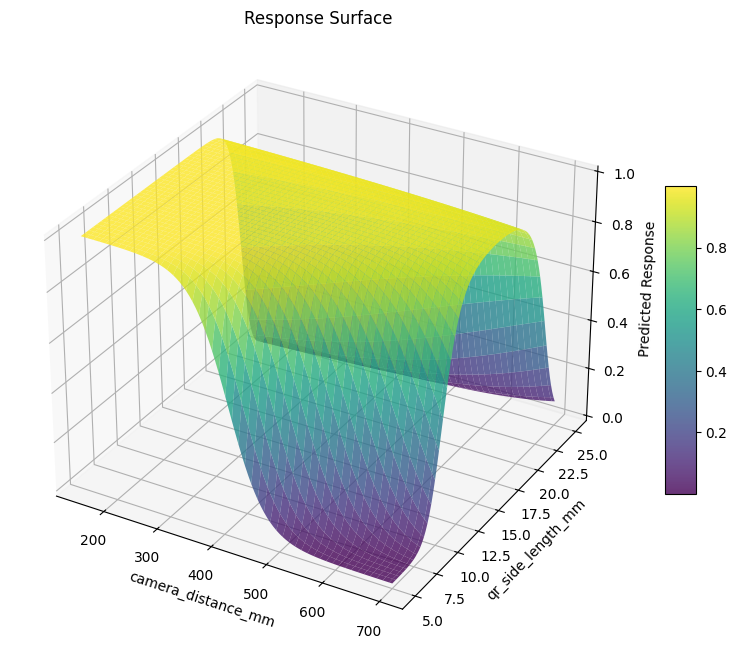

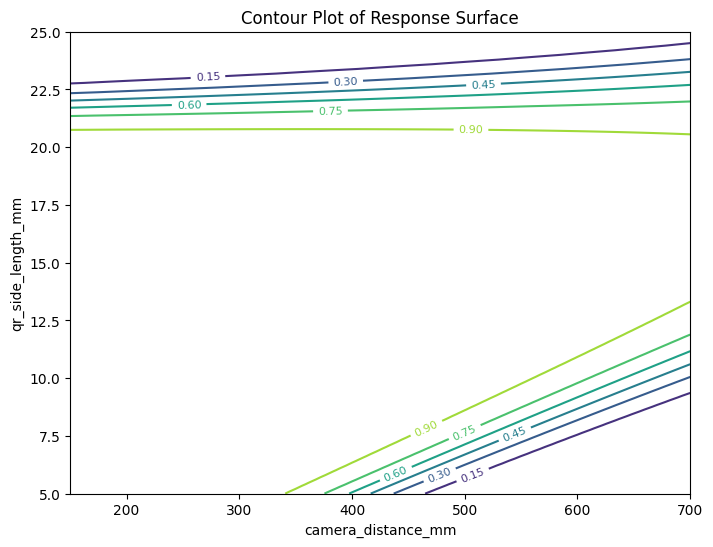

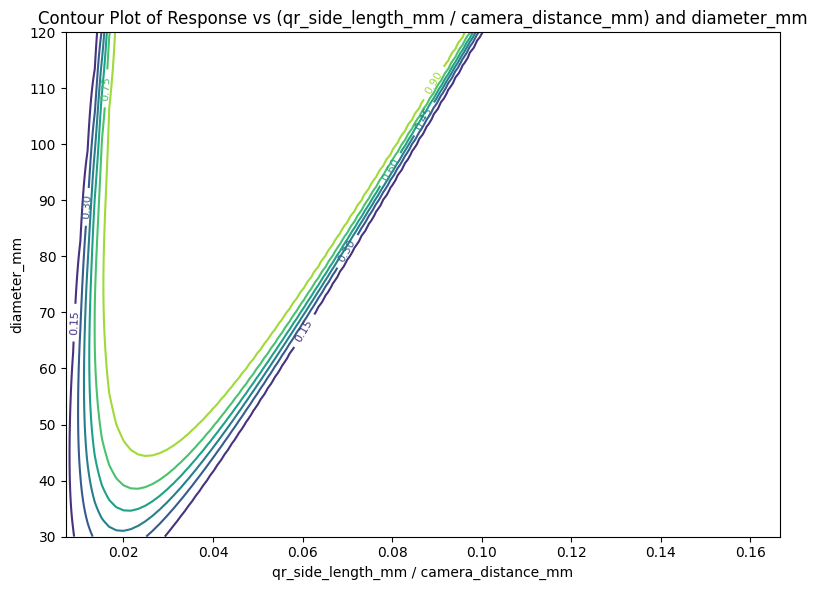


--- Optimization Results ---
Optimal camera_distance_mm: 386.58
Optimal qr_side_length_mm: 15.47
Optimal diameter_mm: 81.10
Optimal Response: 1.0000


In [7]:
primary = ['camera_distance_mm', 'qr_side_length_mm']
secondary = 'diameter_mm'
response = 'pyzbar Correct'
order = 'second'

# Logistic Regression
analyse_data(results, primary, secondary, response, order, regression_type='logistic', plot_ratio_contour=True)